```
From: https://github.com/ksatola
Version: 0.0.5
```

# Model - PM2.5 - Machine Learning Modelling - Regression

## Contents

- [Machine Learning Regression](#mlr)
- Hourly prediction
    - [Load hourly data](#data_h)
    - [Base Modelling](#model_h)
    - [Hyper-parameters Tuning](#model_h_tune)
- Daily prediction
    - [Load daily data](#data_d)
    - [Modelling](#model_d)
    - [Hyper-parameters Tuning](#model_d_tune)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score

In [7]:
#from model import (
    #get_ensemble_models_for_regression,
    #get_analytical_view_for_meta_model,
    #fit_base_models,
    #fit_meta_model,
    #evaluate_models,
    #predict_with_super_learner
#)

from model import (
    get_pm25_data_for_modelling,
    split_df_for_ml_modelling,
    get_models_for_regression
)

from measure import (
    #get_rmse
    score_ml_models
)

#from plot import (
    #plot_train_test_predicted,
#    plot_observed_vs_predicted,
#    plot_observations_to_predictions_relationship,
    #fit_theoretical_dist_and_plot
#)

---
<a id='mlr'></a>

## Machine Learning Regression

XXXXXXXXX

- Linear Algorithms: Logistic Regression.
- Nonlinear Algorithms: Classification and Regression Trees (CART), Support Vector Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

Napisac z scikit learn wstep do regresji

XXXX
<img src="images/super_learner_algorithm_flow_diagram.png" style="width: 800px;"/>
From https://www.degruyter.com/view/journals/sagmb/6/1/article-sagmb.2007.6.1.1309.xml.xml


score models na zbiorze testowym!
zrobic final test wybranych modeli ML na zbiorze testowym i policzyc RMSE -> symulacja predykcji
jesli linear regression jest najlepsze to sprawdzic OLS assumptions dla zbioru danych

---
<a id='data_h'></a>

## Load hourly data

In [8]:
dfh = get_pm25_data_for_modelling('ml', 'h')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 03-Jun-20 18:39:37 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_ml_24hours_lags.hdf
common.py | 43 | get_pm25_data_for_modelling | 03-Jun-20 18:39:37 | INFO: Dataframe size: (96378, 19)


,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,20.936157,23.611710,28.537801,1,1,11,1,1,1,1,1
1,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,20.936157,23.611710,1,1,12,1,1,1,1,1
2,-16.761822,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,20.936157,1,1,13,1,1,1,1,1
3,-6.697300,-16.761822,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,1,1,14,1,1,1,1,1
4,-2.515568,-6.697300,-16.761822,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,1,1,15,1,1,1,1,1


---
<a id='model_h'></a>

## Base Modelling

In [9]:
# Train test split
X_train, X_test, y_train, y_test = split_df_for_ml_modelling(data=dfh, 
                                                             target_col='t', 
                                                             train_size=0.8)

In [10]:
# Define regression models in scope
reg_models = get_models_for_regression()
models = []

for model in reg_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))
('ElasticNet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))
('SVR', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))
('DecisionTreeRegressor', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'))
('KNeighborsRegressor', KNeighborsRegressor(algorithm='auto', leaf_siz

In [11]:
%%time
# Perform initial ranking
scores, results, names = score_ml_models(X_train=X_train,
                                         y_train=y_train,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE", 
                                         seed=123)
for score in scores:
    print(score)

LinearRegression, RMSE 6.65957411419811, (std. dev. 0.24797679013828025)
ElasticNet, RMSE 6.661554475363767, (std. dev. 0.25693123328598905)
SVR, RMSE 10.233044938426854, (std. dev. 0.4100088165603076)
DecisionTreeRegressor, RMSE 9.456092893179248, (std. dev. 0.20927662240175304)
KNeighborsRegressor, RMSE 9.217966522916125, (std. dev. 0.364490621665717)
AdaBoostRegressor, RMSE 9.232439669157156, (std. dev. 0.4034306021382163)
BaggingRegressor, RMSE 7.078077379118675, (std. dev. 0.1507370826850066)
RandomForestRegressor, RMSE 7.0144764807240945, (std. dev. 0.17301072119758656)
ExtraTreesRegressor, RMSE 7.0341519710071, (std. dev. 0.23452597614384532)
CPU times: user 1min 18s, sys: 1.8 s, total: 1min 20s
Wall time: 1min 19s


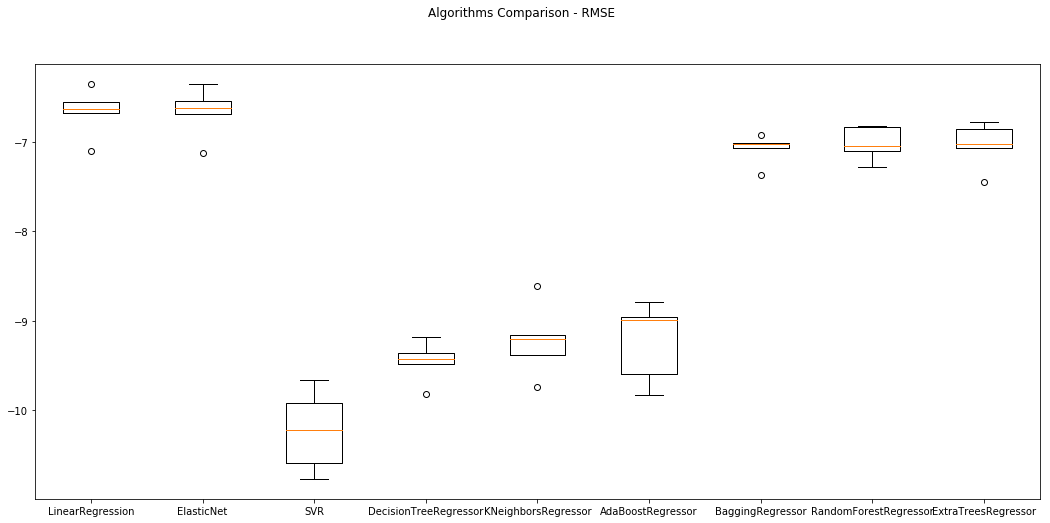

In [12]:
# Compare Algorithms
fig = plt.figure(figsize=(18, 8))
fig.suptitle('Algorithms Comparison - RMSE')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

---
<a id='model_h_tune'></a>

## Hyper-parameter Tuning

`Hyper-parameters` are parameters that are not directly learnt within estimators. It is possible and recommended to search the hyper-parameter space **for the best cross validation score**.

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

A budget can be chosen independent of the number of parameters and possible values.

Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified:

loguniform(1, 100) can be used instead of [1, 10, 100] 

In [13]:
def perform_grid_search_cv2(X_train, y_train, model, param_grid, scoring, num_folds = 6, seed = 123):

    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)

    means = grid_result.cv_results_['mean_test_score'] 
    stds = grid_result.cv_results_['std_test_score'] 
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
    #print('-------')
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

In [14]:
#https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624
def perform_random_search_cv2(X_train, y_train, model, param_grid, scoring, num_folds = 6, seed = 123):

    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            scoring=scoring,
                            verbose=1, 
                            n_jobs=-1,
                            n_iter=1000)
    grid_result = grid.fit(X_train, y_train)

    means = grid_result.cv_results_['mean_test_score'] 
    stds = grid_result.cv_results_['std_test_score'] 
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
    #print('-------')
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

In [18]:
import numpy as np

In [ ]:
%%time
#LinearRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
# Linear regression with combined L1 and L2 priors as regularizer.
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [19]:
%%time
#ElasticNet
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
# Linear regression with combined L1 and L2 priors as regularizer.
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -6.656139464878051 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 100, 'selection': 'cyclic'}
CPU times: user 20min 15s, sys: 8min 36s, total: 28min 52s
Wall time: 5min 40s


In [ ]:
Best: -6.656139464878051 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 100, 'selection': 'cyclic'}
CPU times: user 20min 15s, sys: 8min 36s, total: 28min 52s
Wall time: 5min 40s

In [20]:
%%time
#ElasticNet
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 2396 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3496 tasks      | elapsed:  1.5min


Best: -6.657569882643266 using {'selection': 'cyclic', 'max_iter': 100, 'l1_ratio': 0.9, 'fit_intercept': True, 'alpha': 0.1}
CPU times: user 16.7 s, sys: 1.48 s, total: 18.2 s
Wall time: 1min 35s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.6min finished


In [ ]:
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 2396 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3496 tasks      | elapsed:  1.5min
Best: -6.657569882643266 using {'selection': 'cyclic', 'max_iter': 100, 'l1_ratio': 0.9, 'fit_intercept': True, 'alpha': 0.1}
CPU times: user 16.7 s, sys: 1.48 s, total: 18.2 s
Wall time: 1min 35s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.6min finished

In [ ]:
%%time
#SVR
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# Epsilon-Support Vector Regression. 
# The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.
# The model produced by support vector classification (as described above) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.
param_grid = {
    "kernel": ("linear", "rbf", "poly", "sigmoid"), 
    "degree": [1, 2, 3, 4],
    "C": [1.5, 10],
    "gamma": ["scale", "auto"],
    'epsilon':[0.01, 0.1, 0.2, 0.3, 0.5]
}
model = models[2][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [ ]:
%%time
#SVR
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [ ]:
%%time
#DecisionTreeRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
# Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
param_grid = {
    "criterion": ["mse", "friedman_mse", "mae"],
    "splitter": ["best", "random"],
    "max_depth": range(2, 16, 2),
    "min_samples_split": range(2, 16, 2),
    "min_samples_leaf": range(2, 16, 2),
    "max_features": ["auto", "sqrt", "log2"],
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 1, 10, 100, 1000]
}
model = models[3][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [ ]:
%%time
#BaggingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# https://www.programcreek.com/python/example/85938/sklearn.ensemble.BaggingRegressor
# A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.
# The base estimator to fit on random subsets of the dataset. If None, then the base estimator is a decision tree.
param_grid = {
    "base_estimator": [models[0][1]]
    "n_estimators": [100, 200, 500, 1000, 5000, 10000],
    "bootstrap": [True, False],
    "min_samples_split": range(2, 16, 2),
    "bootstrap": [True, False],
    "n_jobs": [-1]
}
model = models[6][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [ ]:
%%time
#RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://www.programcreek.com/python/example/85938/sklearn.ensemble.BaggingRegressor
# A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
param_grid = {
    "n_estimators": [100, 200, 500, 1000, 5000, 10000],
    "criterion": ["mse", "mae"],
    "bootstrap": [True, False],
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 1, 10, 100, 1000],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": range(2, 16, 2),
    "n_jobs": [-1]
}
model = models[7][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [ ]:
%%time
#ExtraTreesRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
# https://www.programcreek.com/python/example/102434/sklearn.ensemble.ExtraTreesRegressor
# This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
param_grid = {
    "n_estimators": [100, 200, 500, 1000, 5000, 10000],
    "criterion": ["mse", "mae"],
    "bootstrap": [True, False],
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 1, 10, 100, 1000],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": range(2, 16, 2),
    "n_jobs": [-1]
}
model = models[8][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

---
<a id='data_d'></a>

## Load daily data

In [ ]:
dfd = get_pm25_data_for_modelling('ml', 'd')
dfd.head()

---
<a id='model_d'></a>

## Modelling

---
<a id='model_d_tune'></a>

## Hyper-parameter Tuning

In [ ]:
### PRZEGLADNAC TO CO PONIZEJ I USUNAC


https://scikit-learn.org/stable/model_selection.html

https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/

XGBoost: https://machinelearningmastery.com/calculate-feature-importance-with-python/

http://queirozf.com/entries/scikit-learn-pipeline-examples


## Contents

- [Decision Tree](#tree)
- Hourly prediction
    - [Load hourly data](#data_h)
    - [Modelling](#model_h)
- Daily prediction
    - [Load daily data](#data_d)
    - [Modelling](#model_d)

## Grid Search: hyper-parameters tuning
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

Some models allow for specialized, efficient parameter search strategies, outlined below. Two generic approaches to sampling search candidates are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution.

Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior, possibly by reading the enclosed reference to the literature.

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

- A budget can be chosen independent of the number of parameters and possible values.

- Adding parameters that do not influence the performance does not decrease efficiency.

## Cross-validation: evaluating estimator performance
https://scikit-learn.org/stable/modules/cross_validation.html

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using  of the folds as training data;

- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

dac obrazek ze strony, zrobic source: sklearn

## Pipelines and composite estimators
https://scikit-learn.org/stable/modules/compose.html

Transformers are usually combined with classifiers, regressors or other estimators to build a composite estimator. The most common tool is a Pipeline.

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

Convenience and encapsulation
You only have to call fit and predict once on your data to fit a whole sequence of estimators.

Joint parameter selection
You can grid search over parameters of all estimators in the pipeline at once.

Safety
Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

## Model persistence
https://scikit-learn.org/stable/modules/model_persistence.html

After training a scikit-learn model, it is desirable to have a way to persist the model for future use without having to retrain. The following section gives you an example of how to persist a model with pickle. 

pickle (and joblib by extension), has some issues regarding maintainability and security. Because of this,

- Never unpickle untrusted data as it could lead to malicious code being executed upon loading.

- While models saved using one version of scikit-learn might load in other versions, this is entirely unsupported and inadvisable. It should also be kept in mind that operations performed on such data could give different and unexpected results.

In order to rebuild a similar model with future versions of scikit-learn, additional metadata should be saved along the pickled model:

- The training data, e.g. a reference to an immutable snapshot

- The python source code used to generate the model

- The versions of scikit-learn and its dependencies

- The cross validation score obtained on the training data

- This should make it possible to check that the cross-validation score is in the same range as before.

Since a model internal representation may be different on two different architectures, dumping a model on one architecture and loading it on another architecture is not supported.

more: https://pyvideo.org/pycon-us-2014/pickles-are-for-delis-not-software.html

In [ ]:
%autoreload 2

In [ ]:
import sys
sys.path.insert(0, '../src')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#from model import (
#    get_best_arima_params_for_time_series
#)

from measure import (
    get_rmse
)

from plot import (
    #plot_train_test_predicted,
    plot_observed_vs_predicted,
    plot_observations_to_predictions_relationship,
    #fit_theoretical_dist_and_plot
)

In [ ]:
! pwd

In [ ]:
data_path = '/Users/ksatola/Documents/git/air-polution/data/final/'

---
<a id='data_h'></a>

## Load hourly data

In [ ]:
data_file_hdf = data_path + 'dfpm25_2008-2018_ml_24hours_lags.hdf'

df = pd.read_hdf(path_or_buf=data_file_hdf, key="df")
print(f'Dataframe size: {df.shape}')
df.head()

In [ ]:
df.shape

In [ ]:
# Shorten series for faster fitting
#df = df[-(2*365*24):]
#df.shape

---
<a id='model_h'></a>

## Modelling

In [ ]:
# Split dataset into independent variables dataset columns and dependent variable column
X = df.iloc[:, 1:]
y = df.iloc[:, :1]
#y.head()

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [ ]:
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test:  {y_test.shape}')

In [ ]:
%%time
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)

coefficient of determination R^2

The coefficient R^2 is defined as (1 - u/v), where u is the residual
sum of squares ((y_true - y_pred) ** 2).sum() and v is the total
sum of squares ((y_true - y_true.mean()) ** 2).sum().
The best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.0.

In [ ]:
%%time
# Check the score on train and test
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))  # predictions are horrible if negative value, no relationship if 0

In [ ]:
%%time
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# Cross-validation
model = ensemble.GradientBoostingRegressor()
scores = cross_val_score(model, X_train, y_train, cv=5)

In [ ]:
scores

In [ ]:
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
%%time
from sklearn import metrics
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='explained_variance')
scores

In [ ]:
%%time
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
scores

In [ ]:
from sklearn import preprocessing

In [ ]:
%time
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
model = ensemble.GradientBoostingRegressor().fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
model.score(X_test_transformed, y_test)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
%%time
scoring = ['r2', 'explained_variance', 'max_error']
scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
scores

In [ ]:
sorted(scores.keys())

In [ ]:
scores['test_max_error']

In [ ]:
# Find the names and current values for all parameters for a given estimator
model.get_params()

In [ ]:
from sklearn.utils.fixes import loguniform
{'C': loguniform(1e0, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

In [ ]:
n_jobs=-1
error_score=0

In [ ]:
# not recommended
import pickle
s = pickle.dumps(model)
#print(s)
model2 = pickle.loads(s)
model2.predict(X[0:20])

In [ ]:
# recommended
from joblib import dump, load
dump(model, 'model.joblib') 
model2 = load('model.joblib')
model2.predict(X[0:20])

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(ensemble.GradientBoostingRegressor(), 
                                                         X_train, y_train, 
                                                         train_sizes=[50, 80, 110], 
                                                         cv=5)

In [ ]:
# https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = ensemble.GradientBoostingRegressor()#GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
rmse = get_rmse(y_test, y_pred)
print(f'Decision Tree RMSE: {rmse:.4f}')
#print(f'Naive forecast correlation coefficient of the observed-to-predicted values percent change: {r:.4f}')

In [ ]:
# Plot predicted against actual values

#from matplotlib import pyplot as plt

# Use the best max_depth 
model = tree.DecisionTreeRegressor(max_depth=8)  # fill in best max depth here
model.fit(X_train, y_train)

# Predict values for train and test
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

# Scatter the predictions vs actual values
plt.scatter(train_prediction, y_train, label='train')  # blue
plt.scatter(test_prediction, y_test, label='test')  # orange
plt.show();

In [ ]:
# Feature importance
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();

In [ ]:
tree.plot_tree(model)

In [ ]:
model.predict([X_train.iloc[100]])

In [ ]:
y_train.iloc[100]

In [ ]:
# https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [ ]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                feature_names = X_train.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

---
<a id='data_d'></a>

## Load daily data

In [ ]:
data_file = data_path + 'dfpm25_2008-2018_ml_7days_lags.hdf'

df = pd.read_hdf(path_or_buf=data_file, key="df")
print(f'Dataframe size: {df.shape}')
df.head()

---
<a id='model_d'></a>

## Modelling

In [ ]:
# Split dataset into independent variables dataset columns and dependent variable column
X = df.iloc[:, 1:]
y = df.iloc[:, :1]
#y.head()

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [ ]:
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test:  {y_test.shape}')

In [ ]:
%%time
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)

In [ ]:
%%time
# Find the best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.

for d in [2, 3, 4, 5,7,8,10]:
    # Create the tree and fit it
    model = tree.DecisionTreeRegressor(max_depth=d)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = get_rmse(y_test, y_pred)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(model.score(X_train, y_train))
    print(model.score(X_test, y_test))  # You want the test score to be positive and high
    print(f'Decision Tree RMSE: {rmse:.4f}')

In [ ]:
# Plot predicted against actual values

#from matplotlib import pyplot as plt

# Use the best max_depth 
model = tree.DecisionTreeRegressor(max_depth=3)  # fill in best max depth here
model.fit(X_train, y_train)

# Predict values for train and test
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

# Scatter the predictions vs actual values
plt.scatter(train_prediction, y_train, label='train')  # blue
plt.scatter(test_prediction, y_test, label='test')  # orange
plt.show();

In [ ]:
# Feature importance
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();

In [ ]:
tree.plot_tree(model, feature_names=X_train.columns)

In [ ]:
model.predict([X_train.iloc[100]])

In [ ]:
y_train.iloc[100]

In [ ]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())